In [1]:
import pandas as pd
import numpy as np
import time

import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from pdpbox import pdp 

# Baselining #

**Import Clean Data Set**

In [2]:
df_balanced_baseline = pickle.load(open('df_pre_features.pkl', 'rb'))

**Assign X, y and One Hot Encoding**

In [3]:
y = df_balanced_baseline['Outcome Type']
df_balanced_baseline = df_balanced_baseline.drop(['Outcome Type'], axis=1)

In [4]:
# Adding a constant value to replace missing values
df_balanced_baseline['Breed'] = df_balanced_baseline['Breed'].cat.add_categories(-999)
df_balanced_baseline['Color'] = df_balanced_baseline['Color'].cat.add_categories(-999)
df_balanced_baseline['Sterilized'] = df_balanced_baseline['Sterilized'].cat.add_categories(-999)
df_balanced_baseline['Sex'] = df_balanced_baseline['Sex'].cat.add_categories(-999)

In [5]:
# Changing all unknowns and one hot encoding
df_balanced_baseline = df_balanced_baseline.replace('Unknown', np.nan)
df_balanced_baseline = df_balanced_baseline.fillna(-999)
df_balanced_baseline = pd.get_dummies(df_balanced_baseline)

In [6]:
X = df_balanced_baseline

**Label Encode Target**

In [7]:
le = LabelEncoder()
le.fit(y)
new_y = le.transform(y)

**Split Data and Beginning Modeling**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

**Baseline Naive Bays**

In [9]:
nbmodel = GaussianNB()
nbmodel.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [10]:
y_pred = nbmodel.predict(X_val)
print('F1 Score: %.4f'% f1_score(y_val, y_pred, average='macro'))
print(classification_report(y_val, nbmodel.predict(X_val), target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.3722
                   precision    recall  f1-score   support

          Adopted       0.64      0.27      0.37      8287
       Euthanized       0.37      0.89      0.53      6602
Returned To Owner       0.43      0.14      0.21      6428

         accuracy                           0.42     21317
        macro avg       0.48      0.43      0.37     21317
     weighted avg       0.49      0.42      0.37     21317



**Baseline Logistic Regression**

In [11]:
lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_pred = lrmodel.predict(X_val)
print('F1 Score: %.4f'% f1_score(y_val, y_pred, average='macro'))
print(classification_report(y_val, lrmodel.predict(X_val), target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.5634
                   precision    recall  f1-score   support

          Adopted       0.60      0.93      0.73      8287
       Euthanized       0.73      0.80      0.76      6602
Returned To Owner       0.59      0.12      0.19      6428

         accuracy                           0.65     21317
        macro avg       0.64      0.62      0.56     21317
     weighted avg       0.64      0.65      0.58     21317



**Random Forest Baseline**

In [13]:
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
y_pred = rfmodel.predict(X_val)
print('F1 Score: %.4f'% f1_score(y_val, y_pred, average = 'macro'))
print(classification_report(y_val, rfmodel.predict(X_val), target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.6530
                   precision    recall  f1-score   support

          Adopted       0.70      0.76      0.73      8287
       Euthanized       0.75      0.74      0.75      6602
Returned To Owner       0.51      0.46      0.48      6428

         accuracy                           0.66     21317
        macro avg       0.65      0.65      0.65     21317
     weighted avg       0.66      0.66      0.66     21317



## XGBoost Baseline ##

**Importing Feature Engineering Data Set**

In [15]:
# Importing and dropping unneeded feature
df_balanced = pickle.load(open('df_dogs_modeling.pkl', 'rb'))
df_balanced = df_balanced.drop('Days in Shelter', axis=1)

**XGBoost Data Preparation**

In [16]:
df_balanced['Sterilized'] = (df_balanced['Sterilized'].cat.add_categories(-999))
df_balanced['Pure'] = (df_balanced['Pure'].cat.add_categories(-999))
df_balanced['Puppy'] = (df_balanced['Puppy'].cat.add_categories(-999))
df_balanced['Sex'] = (df_balanced['Sex'].cat.add_categories(-999))
df_balanced['Breed'] = (df_balanced['Breed'].cat.add_categories(-999))
df_balanced['Primary Color'] = (df_balanced['Primary Color'].cat.add_categories(-999))
df_balanced['Secondary Color'] = (df_balanced['Secondary Color'].cat.add_categories(-999))
df_balanced['Season'] = (df_balanced['Season'].cat.add_categories(-999))
df_balanced['Group'] = (df_balanced['Group'].cat.add_categories(-999))
df_balanced['Size'] = (df_balanced['Size'].cat.add_categories(-999))

**Assign X, y and One Hot Encode**

In [17]:
y = df_balanced['Outcome Type']
df_balanced = df_balanced.drop(['Outcome Type'], axis=1)

In [18]:
# Changing all unknown and nan values to -999; one hot encoding
df_modeling = df_balanced.replace('Unknown', np.nan)
df_modeling = df_modeling.fillna(-999)
df_modeling = pd.get_dummies(df_modeling)

In [19]:
X = df_modeling

**Label Encode Target**

In [20]:
le = LabelEncoder()
le.fit(y)
new_y = le.transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [22]:
gbm = xgb.XGBClassifier(objective='multi:softprob',
                        num_class=3)

eval_set=[(X_train, y_train), (X_val,y_val)]

In [23]:
%%time
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=50,
                    verbose=True)

[0]	validation_0-merror:0.256446	validation_1-merror:0.260262
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.248737	validation_1-merror:0.252287
[2]	validation_0-merror:0.245563	validation_1-merror:0.248487
[3]	validation_0-merror:0.245313	validation_1-merror:0.248159
[4]	validation_0-merror:0.249019	validation_1-merror:0.253131
[5]	validation_0-merror:0.24622	validation_1-merror:0.249848
[6]	validation_0-merror:0.244625	validation_1-merror:0.248018
[7]	validation_0-merror:0.243749	validation_1-merror:0.247361
[8]	validation_0-merror:0.244031	validation_1-merror:0.247174
[9]	validation_0-merror:0.243984	validation_1-merror:0.246751
[10]	validation_0-merror:0.238636	validation_1-merror:0.240512
[11]	validation_0-merror:0.237041	validation_1-merror:0.239011
[12]	validation_0-merror:0.235305	validation_1-merror:0.237838
[13]	validation_0-merror:0.23

In [24]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_pred, y_val, average = 'macro')

0.8242473918852765

In [25]:
print('F1 Score: %.4f'% f1_score(y_pred, y_val, average='macro'))
print(classification_report(y_val, y_pred, target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.8242
                   precision    recall  f1-score   support

          Adopted       0.83      0.86      0.85      8287
       Euthanized       0.90      0.82      0.86      6602
Returned To Owner       0.74      0.78      0.76      6428

         accuracy                           0.83     21317
        macro avg       0.83      0.82      0.82     21317
     weighted avg       0.83      0.83      0.83     21317



**Feature Importance**

In [26]:
score_weight = gbm.get_booster().get_score(importance_type='weight')
sorted(score_weight.items(), key=lambda kv: kv[1], reverse=True)

[('Percent Breed Outcome Year', 816),
 ('Age at Outcome', 375),
 ('Mean Age at Outcome Breed', 151),
 ('Mean Weight Breed', 118),
 ('Sterilized_Yes', 86),
 ('Rank_2013', 65),
 ('Sterilized_No', 59),
 ('Puppy_No', 55),
 ('Rank_2017', 37),
 ('Median Life Expectancy', 37),
 ('Pure_No', 33),
 ('Sterilized_-999', 27),
 ('Breed_Siberian Husky', 22),
 ('Breed_Chihuahua', 22),
 ('Rank_2016', 18),
 ('Breed_American Pit Bull Terrier', 18),
 ('Sex_Female', 16),
 ('Rank_2014', 11),
 ('Rank_2015', 10),
 ('Sex_-999', 10),
 ('Breed_Alaskan Husky', 9),
 ('Breed_Beagle', 8),
 ('Size_XSmall', 7),
 ('Group_Sporting', 7),
 ('Breed_Boxer', 7),
 ('Group_Working', 6),
 ('Breed_French Bulldog', 6),
 ('Season_Spring', 5),
 ('Breed_Bull Terrier', 4),
 ('Breed_St. Bernard', 4),
 ('Secondary Color_Brindle', 4),
 ('Breed_Miniature Schnauzer', 4),
 ('Group_Toy', 3),
 ('Breed_Belgian Malinois', 3),
 ('Group_-999', 3),
 ('Breed_Rhodesian Ridgeback', 3),
 ('Primary Color_Yellow', 3),
 ('Breed_Catahoula Leopard Dog', 3

In [27]:
score_gain = gbm.get_booster().get_score(importance_type='gain')
sorted(score_gain.items(), key=lambda kv: kv[1], reverse = True)

[('Sterilized_Yes', 1778.3790319923485),
 ('Size_Medium', 331.230316),
 ('Sterilized_No', 267.9714481116949),
 ('Breed_Siberian Husky', 226.14995328636363),
 ('Percent Breed Outcome Year', 193.93580816259913),
 ('Puppy_No', 179.70359719781808),
 ('Age at Outcome', 132.5876685016946),
 ('Breed_St. Bernard', 112.86679842500001),
 ('Rank_2015', 104.29114469999999),
 ('Group_Working', 99.91751038333332),
 ('Breed_Alaskan Husky', 94.37310787777778),
 ('Breed_Chihuahua', 86.54196407181817),
 ('Group_Non-Sporting', 85.75319675),
 ('Mean Age at Outcome Breed', 85.23644794586757),
 ('Breed_American Pit Bull Terrier', 77.74952254444445),
 ('Rank_2013', 77.52324023859998),
 ('Mean Weight Breed', 74.78359513186439),
 ('Rank_2014', 64.02117677272727),
 ('Breed_Bull Terrier', 53.4452591),
 ('Median Life Expectancy', 50.81782085567568),
 ('Group_Toy', 46.8328654),
 ('Rank_2017', 43.50515012027028),
 ('Pure_No', 37.79079692636364),
 ('Rank_2016', 31.263807246499994),
 ('Sex_Female', 29.132323031250003

## XGBoost Tuned ##

**Dropping Features to Decrease Model Complexity**

In [28]:
# Dropping feature with low importance
df_balanced = df_balanced.drop('Sterilized', axis=1)

**Assign X, y and One Hot Encode**

In [29]:
# Changing all unknown and nan values to -999; one hot encoding
df_modeling = df_balanced.replace('Unknown', np.nan)
df_modeling = df_modeling.fillna(-999)
df_modeling = pd.get_dummies(df_modeling)

In [30]:
X = df_modeling

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [32]:
gbm = xgb.XGBClassifier(n_estimators=50000, 
                        max_depth=6,
                        objective='multi:softprob',
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        num_class=3)

eval_set=[(X_train, y_train), (X_val,y_val)]

In [33]:
%%time
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=50,
                    verbose=True)

[0]	validation_0-merror:0.26808	validation_1-merror:0.274147
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.263718	validation_1-merror:0.268846
[2]	validation_0-merror:0.256806	validation_1-merror:0.263639
[3]	validation_0-merror:0.253053	validation_1-merror:0.259183
[4]	validation_0-merror:0.24389	validation_1-merror:0.249003
[5]	validation_0-merror:0.241028	validation_1-merror:0.245626
[6]	validation_0-merror:0.232365	validation_1-merror:0.238026
[7]	validation_0-merror:0.23199	validation_1-merror:0.237604
[8]	validation_0-merror:0.226502	validation_1-merror:0.232725
[9]	validation_0-merror:0.223875	validation_1-merror:0.229347
[10]	validation_0-merror:0.21995	validation_1-merror:0.226204
[11]	validation_0-merror:0.211756	validation_1-merror:0.219168
[12]	validation_0-merror:0.204907	validation_1-merror:0.210442
[13]	validation_0-merror:0.20278

In [34]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_pred, y_val, average = 'macro')

0.959337732881714

In [35]:
print('F1 Score: %.4f'% f1_score(y_pred, y_val, average = 'macro'))
print(classification_report(y_val, y_pred, target_names =  ['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.9593
                   precision    recall  f1-score   support

          Adopted       0.97      0.97      0.97      8287
       Euthanized       0.96      0.96      0.96      6602
Returned To Owner       0.95      0.95      0.95      6428

         accuracy                           0.96     21317
        macro avg       0.96      0.96      0.96     21317
     weighted avg       0.96      0.96      0.96     21317



**Feature Importance**

In [36]:
score_weight = gbm.get_booster().get_score(importance_type='weight')
sorted(score_weight.items(), key=lambda kv: kv[1], reverse = True)

[('Percent Breed Outcome Year', 34002),
 ('Age at Outcome', 14747),
 ('Mean Age at Outcome Breed', 5678),
 ('Mean Weight Breed', 4489),
 ('Rank_2017', 4019),
 ('Median Life Expectancy', 3618),
 ('Pure_No', 2257),
 ('Rank_2013', 1783),
 ('Sex_Female', 1759),
 ('Rank_2016', 1636),
 ('Season_Spring', 1521),
 ('Season_Fall', 1494),
 ('Secondary Color_-999', 1451),
 ('Season_Summer', 1442),
 ('Season_Winter', 1259),
 ('Secondary Color_White', 1129),
 ('Rank_2015', 1066),
 ('Primary Color_Black', 1060),
 ('Primary Color_Brown', 1034),
 ('Rank_2014', 1026),
 ('Puppy_No', 847),
 ('Sex_Male', 776),
 ('Primary Color_White', 769),
 ('Secondary Color_Black', 664),
 ('Primary Color_Tan', 568),
 ('Secondary Color_Brown', 553),
 ('Pure_Yes', 460),
 ('Puppy_Yes', 450),
 ('Secondary Color_Tan', 430),
 ('Primary Color_Tricolor', 380),
 ('Size_Medium', 370),
 ('Group_Working', 369),
 ('Group_Herding', 364),
 ('Primary Color_Red', 356),
 ('Group_Non-Sporting', 316),
 ('Puppy_-999', 307),
 ('Group_Sporting

In [37]:
score_gain = gbm.get_booster().get_score(importance_type='gain')
sorted(score_gain.items(), key=lambda kv: kv[1], reverse = True)

[('Puppy_-999', 24.68255838334135),
 ('Breed_American Pit Bull Terrier', 22.46062563830789),
 ('Breed_Chihuahua', 17.563587561181684),
 ('Size_-999', 15.753811126323528),
 ('Breed_Siberian Husky', 14.47860134633513),
 ('Breed_-999', 12.129589618909096),
 ('Breed_Labrador Retriever', 9.711840260134263),
 ('Breed_Alaskan Husky', 8.705268787207931),
 ('Percent Breed Outcome Year', 8.409656709455769),
 ('Breed_Russell Terrier', 8.359096089633335),
 ('Breed_German Shepherd Dog', 8.330597162940684),
 ('Breed_Beagle', 7.456663120479287),
 ('Puppy_No', 6.965317967591567),
 ('Mean Weight Breed', 5.877024003950161),
 ('Size_XSmall', 5.748916293952425),
 ('Mean Age at Outcome Breed', 5.585841695127823),
 ('Age at Outcome', 5.5627709936879475),
 ('Breed_Poodle', 5.425861266659155),
 ('Breed_St. Bernard', 5.374241533023405),
 ('Sex_-999', 5.264251826052976),
 ('Breed_Parson Russell Terrier', 5.007342637721858),
 ('Breed_Boxer', 4.964589539308074),
 ('Group_Toy', 4.920694198517961),
 ('Group_Working

## XGBoost Tuned Round 2 ##

**Dropping Features to Decrease Model Complexity**

In [38]:
# Dropping feature with low importance
df_balanced = df_balanced.drop('Breed', axis=1)

**Assign X, y and One Hot Encode**

In [39]:
# Changing all unknown and nan values to -999; one hot encoding
df_modeling = df_balanced.replace('Unknown', np.nan)
df_modeling = df_modeling.fillna(-999)
df_modeling = pd.get_dummies(df_modeling)

In [40]:
X = df_modeling

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [42]:
gbm = xgb.XGBClassifier(n_estimators=50000, 
                        max_depth=6,
                        objective='multi:softprob',
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        num_class=3)

eval_set=[(X_train, y_train), (X_val,y_val)]

In [43]:
%%time
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=50,
                    verbose=True)

[0]	validation_0-merror:0.24525	validation_1-merror:0.249848
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.245641	validation_1-merror:0.251208
[2]	validation_0-merror:0.235962	validation_1-merror:0.240559
[3]	validation_0-merror:0.231146	validation_1-merror:0.237745
[4]	validation_0-merror:0.228081	validation_1-merror:0.233663
[5]	validation_0-merror:0.226361	validation_1-merror:0.232537
[6]	validation_0-merror:0.223937	validation_1-merror:0.229723
[7]	validation_0-merror:0.222483	validation_1-merror:0.227002
[8]	validation_0-merror:0.220794	validation_1-merror:0.224797
[9]	validation_0-merror:0.216244	validation_1-merror:0.22081
[10]	validation_0-merror:0.214367	validation_1-merror:0.217901
[11]	validation_0-merror:0.213492	validation_1-merror:0.218511
[12]	validation_0-merror:0.210333	validation_1-merror:0.215462
[13]	validation_0-merror:0.205

In [44]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_pred, y_val, average='macro')

0.9601334140739377

In [45]:
print('F1 Score: %.4f'% f1_score(y_pred, y_val, average='macro'))
print(classification_report(y_val, y_pred, target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.9601
                   precision    recall  f1-score   support

          Adopted       0.97      0.97      0.97      8287
       Euthanized       0.96      0.96      0.96      6602
Returned To Owner       0.95      0.95      0.95      6428

         accuracy                           0.96     21317
        macro avg       0.96      0.96      0.96     21317
     weighted avg       0.96      0.96      0.96     21317



**Feature Importance**

In [46]:
score_weight = gbm.get_booster().get_score(importance_type='weight')
sorted(score_weight.items(), key=lambda kv: kv[1], reverse=True)

[('Percent Breed Outcome Year', 30537),
 ('Age at Outcome', 13388),
 ('Mean Age at Outcome Breed', 8308),
 ('Mean Weight Breed', 6417),
 ('Rank_2017', 6047),
 ('Median Life Expectancy', 5162),
 ('Rank_2013', 2698),
 ('Rank_2016', 2543),
 ('Pure_No', 1832),
 ('Rank_2014', 1595),
 ('Rank_2015', 1502),
 ('Sex_Female', 1352),
 ('Season_Spring', 1259),
 ('Season_Summer', 1223),
 ('Season_Fall', 1184),
 ('Secondary Color_-999', 1160),
 ('Season_Winter', 1021),
 ('Secondary Color_White', 988),
 ('Primary Color_Black', 914),
 ('Primary Color_Brown', 873),
 ('Primary Color_White', 739),
 ('Puppy_No', 664),
 ('Group_Working', 619),
 ('Sex_Male', 590),
 ('Group_Non-Sporting', 585),
 ('Secondary Color_Black', 584),
 ('Group_Herding', 582),
 ('Size_Medium', 577),
 ('Primary Color_Tan', 572),
 ('Group_Sporting', 515),
 ('Secondary Color_Brown', 493),
 ('Group_Terrier', 482),
 ('Secondary Color_Tan', 446),
 ('Size_Large', 440),
 ('Pure_Yes', 424),
 ('Group_Hound', 396),
 ('Puppy_Yes', 388),
 ('Primar

In [47]:
score_gain = gbm.get_booster().get_score(importance_type='gain')
sorted(score_gain.items(), key=lambda kv: kv[1], reverse=True)

[('Size_-999', 15.077125201647924),
 ('Puppy_-999', 14.988872969664365),
 ('Percent Breed Outcome Year', 9.477226064799881),
 ('Puppy_No', 7.246276163389482),
 ('Group_Sporting', 6.3470196957876155),
 ('Age at Outcome', 6.024778683021306),
 ('Group_Non-Sporting and Toy', 5.24190422271),
 ('Group_Working', 5.119852880739283),
 ('Mean Weight Breed', 4.983162139619503),
 ('Group_Toy', 4.904809688667859),
 ('Mean Age at Outcome Breed', 4.663506701724179),
 ('Size_XSmall', 4.625895326318872),
 ('Sex_-999', 4.593418725043716),
 ('Group_Terrier', 4.2354766559087125),
 ('Size_Medium', 4.116025547483826),
 ('Rank_2016', 4.048818333356355),
 ('Rank_2017', 3.9794938136868043),
 ('Rank_2015', 3.797593804970512),
 ('Size_Large', 3.715373602149775),
 ('Group_Herding', 3.6107779346121247),
 ('Median Life Expectancy', 3.533281982938433),
 ('Rank_2013', 3.5147106238309767),
 ('Size_XLarge', 3.2336590731704535),
 ('Size_Small', 3.0826323745083317),
 ('Rank_2014', 2.838615675739062),
 ('Group_Hound', 2.8

## XGBoost Tuned Round 3 ##

**Dropping Features to Decrease Model Complexity**

In [48]:
# Dropping features with low importance
df_balanced = df_balanced.drop('Primary Color', axis=1)
df_balanced = df_balanced.drop('Secondary Color', axis=1)

**Assign X, y and One Hot Encode**

In [49]:
# Changing all unknown and nan values to -999; one hot encoding
df_modeling = df_balanced.replace('Unknown', np.nan)
df_modeling = df_modeling.fillna(-999)
df_modeling = pd.get_dummies(df_modeling)

In [50]:
X = df_modeling

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [52]:
gbm = xgb.XGBClassifier(n_estimators=50000, 
                        max_depth=6,
                        objective='multi:softprob',
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        num_class=3)

eval_set=[(X_train, y_train), (X_val,y_val)]

In [53]:
%%time
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=50,
                    verbose=True)

[0]	validation_0-merror:0.257603	validation_1-merror:0.263452
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.244562	validation_1-merror:0.250833
[2]	validation_0-merror:0.231083	validation_1-merror:0.236947
[3]	validation_0-merror:0.231161	validation_1-merror:0.236243
[4]	validation_0-merror:0.224484	validation_1-merror:0.231318
[5]	validation_0-merror:0.222577	validation_1-merror:0.229066
[6]	validation_0-merror:0.222608	validation_1-merror:0.231505
[7]	validation_0-merror:0.221795	validation_1-merror:0.229301
[8]	validation_0-merror:0.217104	validation_1-merror:0.224844
[9]	validation_0-merror:0.217495	validation_1-merror:0.225876
[10]	validation_0-merror:0.216056	validation_1-merror:0.223812
[11]	validation_0-merror:0.214164	validation_1-merror:0.222733
[12]	validation_0-merror:0.210333	validation_1-merror:0.21837
[13]	validation_0-merror:0.20

In [54]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_pred, y_val, average='macro')

0.9614164774325076

In [55]:
print('F1 Score: %.4f'% f1_score(y_pred, y_val, average='macro'))
print(classification_report(y_val, y_pred, target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.9614
                   precision    recall  f1-score   support

          Adopted       0.97      0.97      0.97      8287
       Euthanized       0.96      0.96      0.96      6602
Returned To Owner       0.95      0.95      0.95      6428

         accuracy                           0.96     21317
        macro avg       0.96      0.96      0.96     21317
     weighted avg       0.96      0.96      0.96     21317



**Feature Importance**

In [56]:
score_weight = gbm.get_booster().get_score(importance_type='weight')
sorted(score_weight.items(), key=lambda kv: kv[1], reverse=True)

[('Percent Breed Outcome Year', 34050),
 ('Age at Outcome', 17408),
 ('Mean Age at Outcome Breed', 9465),
 ('Mean Weight Breed', 7234),
 ('Rank_2017', 7230),
 ('Median Life Expectancy', 5851),
 ('Rank_2013', 3135),
 ('Rank_2016', 2767),
 ('Pure_No', 2267),
 ('Rank_2014', 1786),
 ('Sex_Female', 1783),
 ('Rank_2015', 1734),
 ('Season_Spring', 1590),
 ('Season_Fall', 1474),
 ('Season_Summer', 1469),
 ('Season_Winter', 1311),
 ('Sex_Male', 900),
 ('Puppy_No', 801),
 ('Group_Non-Sporting', 683),
 ('Group_Working', 655),
 ('Group_Herding', 644),
 ('Size_Medium', 618),
 ('Group_Sporting', 604),
 ('Group_Terrier', 552),
 ('Pure_Yes', 460),
 ('Group_Hound', 450),
 ('Puppy_Yes', 446),
 ('Size_Large', 438),
 ('Size_Small', 393),
 ('Puppy_-999', 340),
 ('Group_Toy', 331),
 ('Group_-999', 317),
 ('Sex_-999', 223),
 ('Size_XSmall', 222),
 ('Puppy_', 172),
 ('Group_Miscellaneous', 171),
 ('Size_XLarge', 112),
 ('Group_Non-Sporting and Toy', 74),
 ('Size_-999', 73),
 ('Season_-999', 55),
 ('Group_Terr

In [57]:
score_gain = gbm.get_booster().get_score(importance_type='gain')
sorted(score_gain.items(), key=lambda kv: kv[1], reverse=True)

[('Puppy_-999', 23.18124616069796),
 ('Percent Breed Outcome Year', 8.35417986092273),
 ('Puppy_No', 7.659544877718073),
 ('Size_-999', 6.222994940041098),
 ('Group_Non-Sporting and Toy', 5.810602205408109),
 ('Group_Toy', 5.714986568359151),
 ('Size_XSmall', 5.574506091464549),
 ('Group_Working', 5.3207693595707966),
 ('Size_Medium', 4.924520643571198),
 ('Age at Outcome', 4.679973691979642),
 ('Mean Age at Outcome Breed', 4.4943330177211305),
 ('Group_Sporting', 4.389256035863972),
 ('Mean Weight Breed', 4.319313573629468),
 ('Group_Terrier', 4.183998092718599),
 ('Sex_-999', 3.9951216716044855),
 ('Size_Large', 3.8719194727431057),
 ('Rank_2016', 3.8546694830214316),
 ('Rank_2013', 3.473277644669421),
 ('Rank_2017', 3.4223524437909845),
 ('Rank_2015', 3.4080120977264077),
 ('Group_Herding', 3.2684395086216598),
 ('Median Life Expectancy', 3.259628272196238),
 ('Size_XLarge', 3.08427495616893),
 ('Puppy_Yes', 2.5496852660931983),
 ('Pure_Yes', 2.507059552142317),
 ('Group_Non-Sportin

## XGBoost Tuned Round 4 ##

**Dropping Features to Decrease Model Complexity**

In [58]:
# Dropping feature with low importance
df_balanced = df_balanced.drop('Season', axis=1)
df_balanced = df_balanced.drop('Puppy', axis=1)
df_balanced = df_balanced.drop('Sex', axis=1)
df_balanced = df_balanced.drop(['Rank_2013', 'Rank_2014', 'Rank_2015', 'Rank_2016'], axis=1)

**Assign X, y and One Hot Encode**

In [59]:
# Changing all unknown and nan values to -999; one hot encoding
df_modeling = df_balanced.replace('Unknown', np.nan)
df_modeling = df_modeling.fillna(-999)
df_modeling = pd.get_dummies(df_modeling)

In [60]:
X = df_modeling

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [62]:
gbm = xgb.XGBClassifier(n_estimators=50000, 
                        max_depth=6,
                        objective='multi:softprob',
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        num_class=3)

eval_set=[(X_train, y_train), (X_val,y_val)]

In [63]:
%%time
fit_model = gbm.fit(X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=50,
                    verbose=True)

[0]	validation_0-merror:0.245219	validation_1-merror:0.253178
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.224469	validation_1-merror:0.231787
[2]	validation_0-merror:0.21013	validation_1-merror:0.213961
[3]	validation_0-merror:0.214758	validation_1-merror:0.219027
[4]	validation_0-merror:0.211021	validation_1-merror:0.217151
[5]	validation_0-merror:0.20941	validation_1-merror:0.214758
[6]	validation_0-merror:0.210036	validation_1-merror:0.215931
[7]	validation_0-merror:0.213476	validation_1-merror:0.217995
[8]	validation_0-merror:0.214602	validation_1-merror:0.21959
[9]	validation_0-merror:0.208847	validation_1-merror:0.213961
[10]	validation_0-merror:0.206361	validation_1-merror:0.210865
[11]	validation_0-merror:0.203468	validation_1-merror:0.209223
[12]	validation_0-merror:0.197792	validation_1-merror:0.202561
[13]	validation_0-merror:0.1974

In [64]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_pred, y_val, average='macro')

0.9629252950446908

In [65]:
print('F1 Score: %.4f'% f1_score(y_pred, y_val, average='macro'))
print(classification_report(y_val, y_pred, target_names=['Adopted', 'Euthanized', 'Returned To Owner']))

F1 Score: 0.9629
                   precision    recall  f1-score   support

          Adopted       0.97      0.97      0.97      8287
       Euthanized       0.97      0.97      0.97      6602
Returned To Owner       0.96      0.95      0.95      6428

         accuracy                           0.96     21317
        macro avg       0.96      0.96      0.96     21317
     weighted avg       0.96      0.96      0.96     21317



**Feature Importance**

In [66]:
score_weight = gbm.get_booster().get_score(importance_type='weight')
sorted(score_weight.items(), key=lambda kv: kv[1], reverse=True)

[('Percent Breed Outcome Year', 36256),
 ('Age at Outcome', 21461),
 ('Mean Age at Outcome Breed', 12053),
 ('Rank_2017', 11995),
 ('Mean Weight Breed', 9198),
 ('Median Life Expectancy', 7590),
 ('Pure_No', 3379),
 ('Group_Terrier', 833),
 ('Group_Herding', 773),
 ('Group_Non-Sporting', 769),
 ('Group_Working', 760),
 ('Group_Sporting', 704),
 ('Pure_Yes', 699),
 ('Group_Hound', 678),
 ('Size_Medium', 674),
 ('Size_Large', 609),
 ('Size_Small', 505),
 ('Group_Toy', 403),
 ('Group_-999', 336),
 ('Size_XSmall', 244),
 ('Group_Miscellaneous', 205),
 ('Size_XLarge', 143),
 ('Size_-999', 104),
 ('Group_Non-Sporting and Toy', 97),
 ('Group_Terrierand Toy', 78)]

In [67]:
score_gain = gbm.get_booster().get_score(importance_type='gain')
sorted(score_gain.items(), key=lambda kv: kv[1], reverse=True)

[('Percent Breed Outcome Year', 8.138929971794253),
 ('Group_Non-Sporting and Toy', 5.391140882669073),
 ('Size_-999', 5.2862319063049),
 ('Group_Sporting', 4.742655385540209),
 ('Size_Medium', 4.533417093098884),
 ('Group_Working', 4.515979356496314),
 ('Age at Outcome', 4.313017664589728),
 ('Size_XSmall', 3.967782236241394),
 ('Mean Age at Outcome Breed', 3.958047199457237),
 ('Mean Weight Breed', 3.9012870482918927),
 ('Group_Toy', 3.8352059729941863),
 ('Group_Terrier', 3.469478424249449),
 ('Size_Large', 3.271551824324993),
 ('Rank_2017', 3.128571049922069),
 ('Median Life Expectancy', 3.0060834664253413),
 ('Group_Herding', 2.989845001945755),
 ('Group_Non-Sporting', 2.4446587635704966),
 ('Size_XLarge', 2.4109273412622376),
 ('Group_-999', 2.0824995555122),
 ('Size_Small', 2.0206925218593477),
 ('Group_Hound', 1.8798604483334582),
 ('Pure_Yes', 1.0981536980574074),
 ('Pure_No', 1.0950073100602074),
 ('Group_Terrierand Toy', 0.8919059114378205),
 ('Group_Miscellaneous', 0.766555

In [68]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
np.mean(cross_val_score(gbm, X_train, y_train, cv=kfold))

0.9587183815046851

# Visualizations #

**Partial Dependence Plot**

In [69]:
pdp_feat = pdp.pdp_isolate(model=gbm,
                           dataset=X_train,
                           model_features=list(X_train),
                           feature='Age at Outcome')

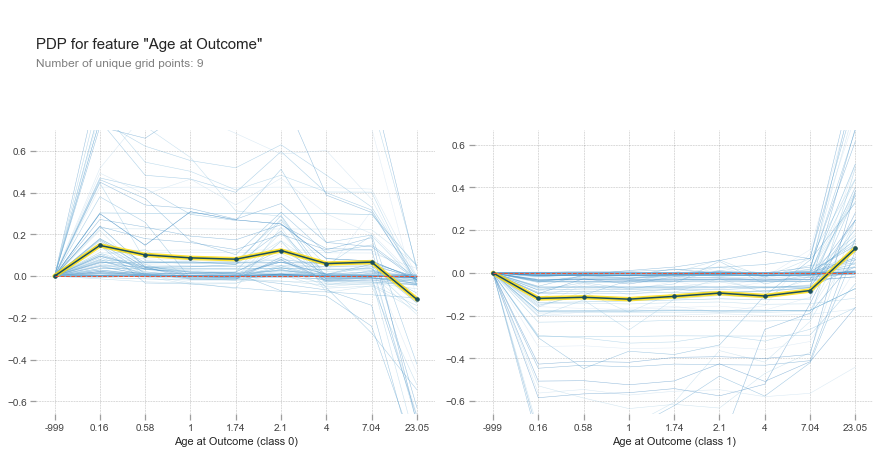

In [70]:
fig, axes = pdp.pdp_plot(pdp_feat,
                         'Age at Outcome',
                         center=True,
                         x_quantile=True,
                         ncols=2,
                         plot_lines=True,
                         frac_to_plot=100,
                         which_classes=[0, 1],
                         plot_pts_dist=False,
                         show_percentile=False)